In [ ]:
%%capture
! pip install jax
! pip install -q equinox optax

## Setup

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
import jax
import optax
import itertools
import jax.numpy as jnp
import numpy as np
import equinox as eqx
import matplotlib.pyplot as plt
import scipy.special as scp

from jax.nn import relu
from tqdm import tqdm
from IPython import display
from jax import config, random, grad, jit, vmap
from scipy.special import roots_legendre
from jax.lax import scan
from functools import partial
from scipy.sparse import coo_matrix
from collections import namedtuple
from scipy.sparse.linalg import spsolve
from typing import Callable
from jax.lax import dot_general

%matplotlib inline
%config InlineBackend.figure_format='retina'

# Datasets

##  Functions needed to generate datasets

In [ ]:
def tent(x, center, h):
    left_mask = (x <= center) & (x >= (center - h))
    right_mask = (x > center) & (x <= (center + h))
    y = (x - center)/h
    return (1. - y) * right_mask + (1. + y) * left_mask

def d_tent(x, center, h):
    left_mask = (x < center) & (x >= (center - h))
    right_mask = (x > center) & (x <= (center + h))
    return (-1. * right_mask + left_mask) / h

def BVP_DD(N_points, F, BCs, M_int=8, conservative=False):
    # for conservative discretization this function was tested only for homogeneous Dirichlet BCs
    a, d, c, f = F # 2, 1, 0 derivatives and right-hand side
    y, w = roots_legendre(M_int)
    w = jnp.array(w)
    w_ = jnp.hstack([w, w])
    h = 1/(N_points+1)
    data = [h, jnp.array(y), w_]

    def compute_coefficients(data, x):
        h, y, w = data
        coefficients = jnp.zeros(4)
        y_ = jnp.hstack([x - h/2 + y*h/2, x + h/2 + y*h/2])
        a_ = -a(y_)*d_tent(y_, x, h)
        d_ = d(y_)*tent(y_, x, h)
        c_ = c(y_)*tent(y_, x, h)
        for i, j in enumerate([-1, 0, 1]):
            values = (a_*d_tent(y_, x+j*h, h) + d_*d_tent(y_, x+j*h, h) + c_*tent(y_, x+j*h, h))
            coefficients = coefficients.at[i].set(jnp.sum(values*w))
        coefficients = coefficients.at[-1].set(jnp.sum(tent(y_, x, h)*f(y_)*w))
        return data, coefficients


    def compute_coefficients_c(data, x):
        h, y, w = data
        coefficients = jnp.zeros(4)
        y_ = jnp.hstack([x - h/2 + y*h/2, x + h/2 + y*h/2])
        a_ = -a(y_)*d_tent(y_, x, h)
        d_ = -d(y_)*d_tent(y_, x, h)
        c_ = c(y_)*tent(y_, x, h)
        for i, j in enumerate([-1, 0, 1]):
            values = (a_*d_tent(y_, x+j*h, h) + d_*tent(y_, x+j*h, h) + c_*tent(y_, x+j*h, h))
            coefficients = coefficients.at[i].set(jnp.sum(values*w))
        coefficients = coefficients.at[-1].set(jnp.sum(tent(y_, x, h)*f(y_)*w))
        return data, coefficients

    x = jnp.linspace(0, 1, N_points+2)[1:-1]

    compute_coefficients_ = compute_coefficients_c if conservative else compute_coefficients
    _, coeff = scan(compute_coefficients_, data, x)

    y_ = h/2 + y * h/2
    if conservative:
        l = jnp.sum((-a(y_)*d_tent(y_, h, h)*d_tent(y_, 0, h) - d(y_)*d_tent(y_, h, h)*tent(y_, 0, h) + c(y_)*tent(y_, h, h)*tent(y_, 0, h))*w)
    else:
        l = jnp.sum((-a(y_)*d_tent(y_, h, h)*d_tent(y_, 0, h) + d(y_)*tent(y_, h, h)*d_tent(y_, 0, h) + c(y_)*tent(y_, h, h)*tent(y_, 0, h))*w)
    y_ = 1 - h/2 + y * h/2
    if conservative:
        r = jnp.sum((-a(y_)*d_tent(y_, 1-h, h)*d_tent(y_, 1, h) - d(y_)*d_tent(y_, 1-h, h)*tent(y_, 1, h) + c(y_)*tent(y_, 1-h, h)*tent(y_, 1, h))*w)
    else:
        r = jnp.sum((-a(y_)*d_tent(y_, 1-h, h)*d_tent(y_, 1, h) + d(y_)*tent(y_, 1-h, h)*d_tent(y_, 1, h) + c(y_)*tent(y_, 1-h, h)*tent(y_, 1, h))*w)

    # correct boundary conditions
    coeff = coeff.at[0, -1].set(coeff[0, -1] - l*BCs[0])
    coeff = coeff.at[-1, -1].set(coeff[-1, -1] - r*BCs[1])
    return coeff

def solve_BVP(N_points, F, BCs, M_int=8):
    coeff = BVP_DD(N_points-2, F, BCs, M_int=M_int)
    L = jnp.diag(coeff[:, 1]) + jnp.diag(coeff[1:, 0], k=-1) + jnp.diag(coeff[:-1, 2], k=+1)
    sol = jnp.linalg.solve(L, coeff[:, -1])
    sol = jnp.hstack([BCs[0], sol, BCs[1]])
    return sol

def FEM_2D(N_points, F, M_int=8, backend="jax"):
    # dx (a1 dx) + dy (a2 dy) + dx (a12 dy) + dy (a21 dx) + dx b1 + dy b2 + c
    a1, a2, a12, a21, b1, b2, c, f = F
    coords, w = roots_legendre(M_int)
    w = jnp.array(w)
    w_ = jnp.hstack([w, w])
    ind = []
    values = []
    rhs = []
    h = 1/(N_points+1)
    lex = lambda i, j: i + N_points*j

    def discretization(carry, ind):
        w_, coords, h  = carry
        j, i = ind[0], ind[1]
        x, y = (i+1)*h, (j+1)*h
        x_ = jnp.hstack([x - h/2 + coords*h/2, x + h/2 + coords*h/2])
        y_ = jnp.hstack([y - h/2 + coords*h/2, y + h/2 + coords*h/2])
        X_, Y_ = jnp.meshgrid(x_, y_, indexing="ij")
        a_1 = - a1(X_, Y_) * d_tent(x_, x, h).reshape(-1, 1) * tent(y_, y, h).reshape(1, -1)
        a_12 = - a12(X_, Y_) * d_tent(x_, x, h).reshape(-1, 1) * tent(y_, y, h).reshape(1, -1)
        a_2 = - a2(X_, Y_) * d_tent(y_, y, h).reshape(1, -1) * tent(x_, x, h).reshape(-1, 1)
        a_21 = - a21(X_, Y_) * d_tent(y_, y, h).reshape(1, -1) * tent(x_, x, h).reshape(-1, 1)
        b_1 = - b1(X_, Y_) * d_tent(x_, x, h).reshape(-1, 1) * tent(y_, y, h).reshape(1, -1)
        b_2 = - b2(X_, Y_) * d_tent(y_, y, h).reshape(1, -1) * tent(x_, x, h).reshape(-1, 1)
        c_ = c(X_, Y_) * tent(x_, x, h).reshape(-1, 1) * tent(y_, y, h).reshape(1, -1)
        res = [] # row, col, value, i, j
        for p1, p2 in itertools.product([-1, 0, +1], repeat=2):
            v = a_1 * d_tent(x_, x + p1*h, h).reshape(-1, 1) * tent(y_, y + p2*h, h).reshape(1, -1)
            v += a_12 * d_tent(y_, y + p2*h, h).reshape(1, -1) * tent(x_, x + p1*h, h).reshape(-1, 1)
            v += a_2 * d_tent(y_, y + p2*h, h).reshape(1, -1) * tent(x_, x + p1*h, h).reshape(-1, 1)
            v += a_21 * d_tent(x_, x + p1*h, h).reshape(-1, 1) * tent(y_, y + p2*h, h).reshape(1, -1)
            v += (b_1 + b_2 + c_) * tent(y_, y + p2*h, h).reshape(1, -1) * tent(x_, x + p1*h, h).reshape(-1, 1)
            res += [[lex(i, j), lex(i+p1, j+p2), w_ @ v @ w_, i + p1, j + p2]]
        return carry, jnp.array(res)

    def rhs_discretization(carry, ind):
        w_, coords, h  = carry
        j, i = ind[0], ind[1]
        x, y = (i+1)*h, (j+1)*h
        x_ = jnp.hstack([x - h/2 + coords*h/2, x + h/2 + coords*h/2])
        y_ = jnp.hstack([y - h/2 + coords*h/2, y + h/2 + coords*h/2])
        X_, Y_ = jnp.meshgrid(x_, y_, indexing="ij")
        res = w_ @ (f(X_, Y_) * tent(x_, x, h).reshape(-1, 1) * tent(y_, y, h).reshape(1, -1)) @ w_
        return carry, res

    xs = jnp.array([*itertools.product(range(N_points), repeat=2)])
    carry = [w_, coords, h]
    carry, res = scan(discretization, carry, xs)
    carry, rhs = scan(rhs_discretization, carry, xs)

    for_mask = jnp.array(res[:, :, 3:], dtype=int)
    mask = ((for_mask[:, :, 0] < N_points) & (0 <= for_mask[:, :, 0]) & (for_mask[:, :, 1] < N_points) & (0 <= for_mask[:, :, 1])).reshape(-1, )
    res = res[:, :, :3].reshape(-1, 3)[mask]
    ind = jnp.array(res[:, :2], dtype=int)
    values = res[:, 2]
    if backend == "jax":
        return rhs, BCOO((values, ind), shape=(N_points**2, N_points**2))
    else:
        return np.array(rhs), coo_matrix((np.array(values), (np.array(ind[:, 0]), np.array(ind[:, 1]))), shape=(N_points**2, N_points**2)).tocsr()

def solve_BVP_2D_scipy(N_points, F):
    rhs, A = FEM_2D(N_points-2, F, M_int=8, backend="scipy")
    sol_ = spsolve(A, rhs)
    sol = np.zeros((N_points, N_points))
    sol[1:-1, 1:-1] = sol_.reshape((N_points-2, N_points-2))
    return jnp.array(sol.reshape(-1,))

def trapz_indefinite(f, h):
    return (jnp.cumsum(f) - f[:1]/2 - f/2) * h

def solve_BVP_int(a, f, x):
    # solving -d/dx a(x) d/dx u(x) = f(x)
    f_int = trapz_indefinite(-f, x[1] - x[0])
    a_inv_int = trapz_indefinite(1/a, x[1] - x[0])
    sol_1 = trapz_indefinite(f_int/a, x[1] - x[0])
    sol_2 = a_inv_int * (-sol_1[-1]/a_inv_int[-1])
    sol = sol_1 + sol_2
    d_sol = f_int / a - sol_1[-1]/a_inv_int[-1] / a
    flux = f_int - sol_1[-1]/a_inv_int[-1]
    return sol, -flux, d_sol

> `Dataset 1`:
\begin{equation}
\frac{d}{dx}\left(a(x) \frac{d}{dx}u(x)\right) + c(x)u(x) = f(x), \\
x \in [0, ~1],~u(0)=0, ~u(1)=0.
\end{equation}

> `Dataset 2`:
\begin{equation}
\frac{d}{dx}\left(a(x) \frac{d}{dx}u(x)\right) = f(x), \\
x \in [0, ~1],~u(0)=0, ~u(1)=0.
\end{equation}

> `Dataset 3`:
\begin{equation}
\frac{d}{dx}\left(a(x) \frac{d}{dx}u(x)\right) = f(x), \\
x \in [0, ~1],~u(0)=0, ~u(1)=0,
\end{equation}

where $f(x)$ is fixed for all samples.

### Dataset 1:

In [ ]:
Config = namedtuple('Config', ['N_points', 'N_samples'])
args = Config(N_points=101, N_samples=1400)

In [ ]:
@partial(jax.jit, static_argnums=(2,))
def get_dataset_1(state, key, N_points):
    a, c, f, s = state[0][0], state[0][1], state[0][2], state[1]

    keys = random.split(key, 3)

    coeff1 = random.normal(keys[0], (5,), dtype=jnp.complex128)
    coeff2 = random.normal(keys[1], (5,), dtype=jnp.complex128)
    coeff3 = random.normal(keys[2], (5,), dtype=jnp.complex128)

    a = lambda x: -(jnp.real(0.1 * jnp.sum(jnp.stack([jnp.exp(1j * 2 * jnp.pi * x * k) * coeff1[k] for k in range(coeff1.size)], 0), 0))**2 + 1)
    d = lambda x: jnp.zeros_like(x)
    c = lambda x: jnp.real(0.2 * jnp.sum(jnp.stack([jnp.exp(1j * 2 * jnp.pi * x * k) * coeff2[k] for k in range(coeff2.size)], 0), 0))
    f = lambda x: jnp.real(jnp.sum(jnp.stack([jnp.exp(1j * 2 * jnp.pi * x * k) * coeff3[k] for k in range(coeff3.size)], 0), 0))

    F = [a, d, c, f]
    BCs = [0, 0]

    x = jnp.linspace(0, 1, N_points)
    features = jnp.vstack((-a(x), c(x), f(x)))
    solution = solve_BVP(N_points, F, BCs)
    state = [features, solution]

    return state, state

In [ ]:
key = random.PRNGKey(11)

dataset_1_ = partial(get_dataset_1, N_points=args.N_points)

initial_features_1 = jnp.stack([jnp.zeros(shape=(args.N_points, )) for _ in range(3)], axis=1).T
initial_targets_1 = jnp.zeros(shape=(args.N_points, ))
initial_1 = [initial_features_1, initial_targets_1]

_, datasets_1 = jax.lax.scan(dataset_1_, initial_1, random.split(key, args.N_samples))

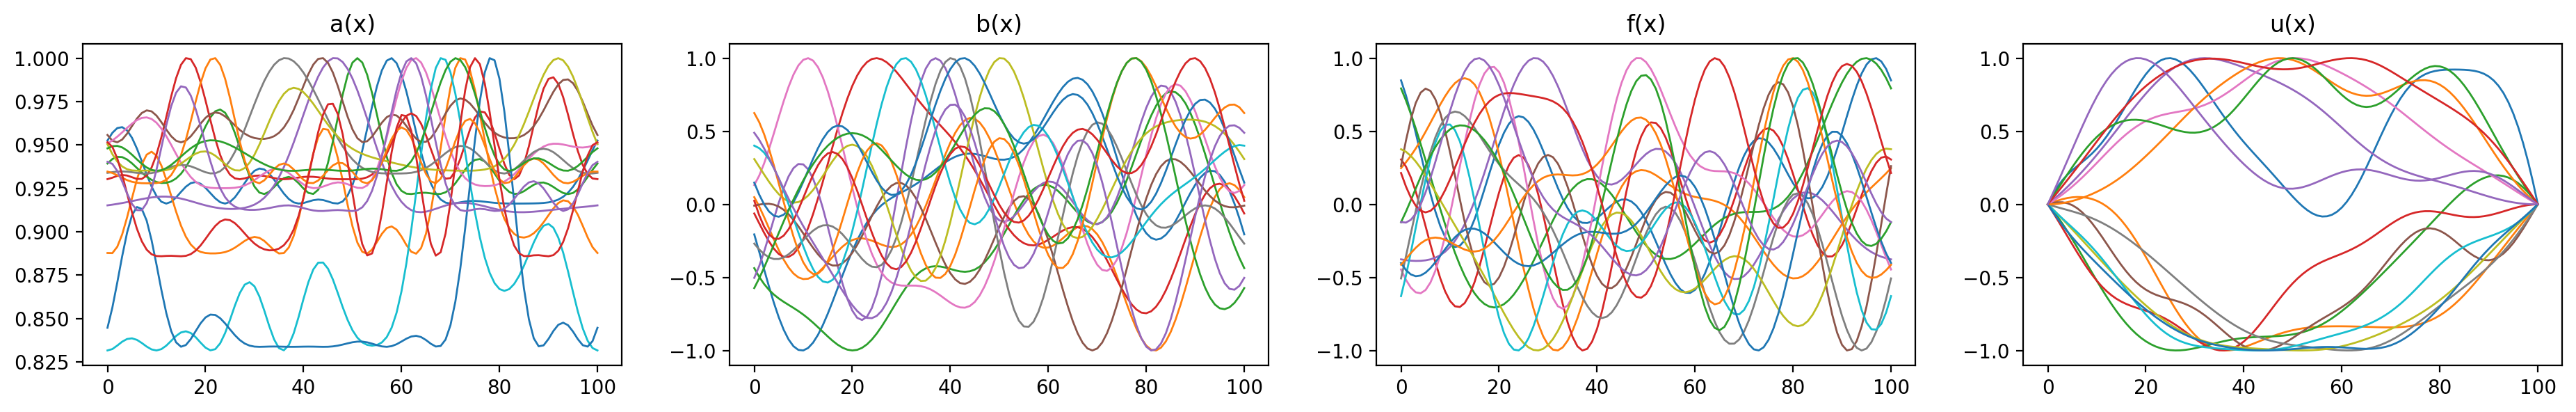

In [ ]:
fig, ax = plt.subplots(1, 4, figsize=(23, 3))

for i, n in enumerate([r"a(x)", r"b(x)", r"f(x)", r"u(x)"]):
    ax[i].set_title(n)

for s in range(15):
    for i in range(datasets_1[0].shape[1]):
        ax[i].plot(datasets_1[0][s, i] / jnp.max(abs(datasets_1[0][s, i])), linewidth=1.0)
    ax[-1].plot(datasets_1[1][s] / jnp.max(abs(datasets_1[1][s])), linewidth=1.0)

### Dataset 2:

In [ ]:
@partial(jax.jit, static_argnums=(2,))
def get_dataset_2(state, key, N_points):
    a, f, s = state[0][0], state[0][1], state[1]

    keys = random.split(key, 2)

    coeff1 = random.normal(keys[0], (5,), dtype=jnp.complex128)
    coeff2 = random.normal(keys[1], (5,), dtype=jnp.complex128)

    a = lambda x: -(jnp.real(0.1 * jnp.sum(jnp.stack([jnp.exp(1j * 2 * jnp.pi * x * k) * coeff1[k] for k in range(coeff1.size)], 0), 0))**2 + 1)
    d = lambda x: jnp.zeros_like(x)
    c = lambda x: jnp.zeros_like(x)
    f = lambda x: jnp.real(jnp.sum(jnp.stack([jnp.exp(1j * 2 * jnp.pi * x * k) * coeff2[k] for k in range(coeff2.size)], 0), 0))

    F = [a, d, c, f]
    BCs = [0, 0]

    x = jnp.linspace(0, 1, N_points)

    features = jnp.vstack((-a(x), f(x)))
    solution = solve_BVP(N_points, F, BCs)
    state = [features, solution]

    return state, state

In [ ]:
key = random.PRNGKey(42)

dataset_2_ = partial(get_dataset_2, N_points=args.N_points)

initial_features_2 = jnp.stack([jnp.zeros(shape=(args.N_points, )) for _ in range(2)], axis=1).T
initial_targets_2 = jnp.zeros(shape=(args.N_points, ))
initial_2 = [initial_features_2, initial_targets_2]

_, datasets_2 = jax.lax.scan(dataset_2_, initial_2, random.split(key, args.N_samples))

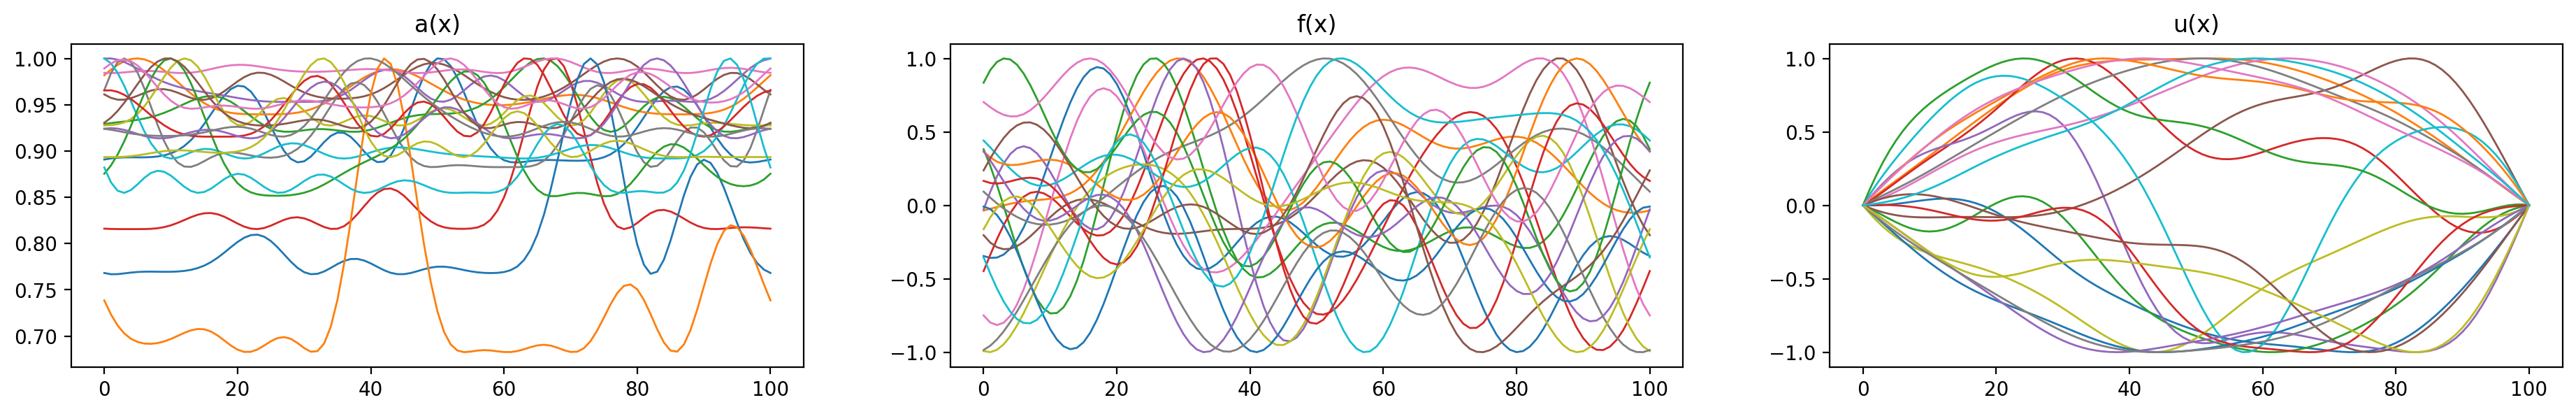

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(23, 3))

for i, n in enumerate([r"a(x)", r"f(x)", r"u(x)"]):
    ax[i].set_title(n)

for s in range(20):
    for i in range(datasets_2[0].shape[1]):
        ax[i].plot(datasets_2[0][s, i] / jnp.max(abs(datasets_2[0][s, i])), linewidth=1.0)
    ax[-1].plot(datasets_2[1][s] / jnp.max(abs(datasets_2[1][s])), linewidth=1.0)

### Dataset 3

In [ ]:
@partial(jax.jit, static_argnums=(2,))
def get_dataset_3(state, key, N_points):
    a, f, s = state[0][0], state[0][1], state[1]

    keys = random.split(key, 2)

    coeff1 = random.normal(keys[0], (5,), dtype=jnp.complex128)
    coeff2 = random.normal(random.PRNGKey(123), (5,), dtype=jnp.complex128)

    alpha, beta = jnp.sort(random.uniform(keys[1], (2,)))
    a = lambda x: -(9*(x >= alpha)*(x <= beta) + 1)
    d = lambda x: jnp.zeros_like(x)
    c = lambda x: jnp.zeros_like(x)
    f = lambda x: jnp.real(jnp.sum(jnp.stack([jnp.exp(1j * 2 * jnp.pi * x * k) * coeff2[k] for k in range(coeff2.size)], 0), 0))

    F = [a, d, c, f]
    BCs = [0, 0]

    x = jnp.linspace(0, 1, N_points)

    features = jnp.vstack((-a(x), f(x)))
    solution = solve_BVP(N_points, F, BCs)
    state = [features, solution]

    return state, state

In [ ]:
key = random.PRNGKey(42)

dataset_3_ = partial(get_dataset_3, N_points=args.N_points)

initial_features_3 = jnp.stack([jnp.zeros(shape=(args.N_points, )) for _ in range(2)], axis=1).T
initial_targets_3 = jnp.zeros(shape=(args.N_points, ))
initial_3 = [initial_features_3, initial_targets_3]

_, datasets_3 = jax.lax.scan(dataset_3_, initial_3, random.split(key, args.N_samples))

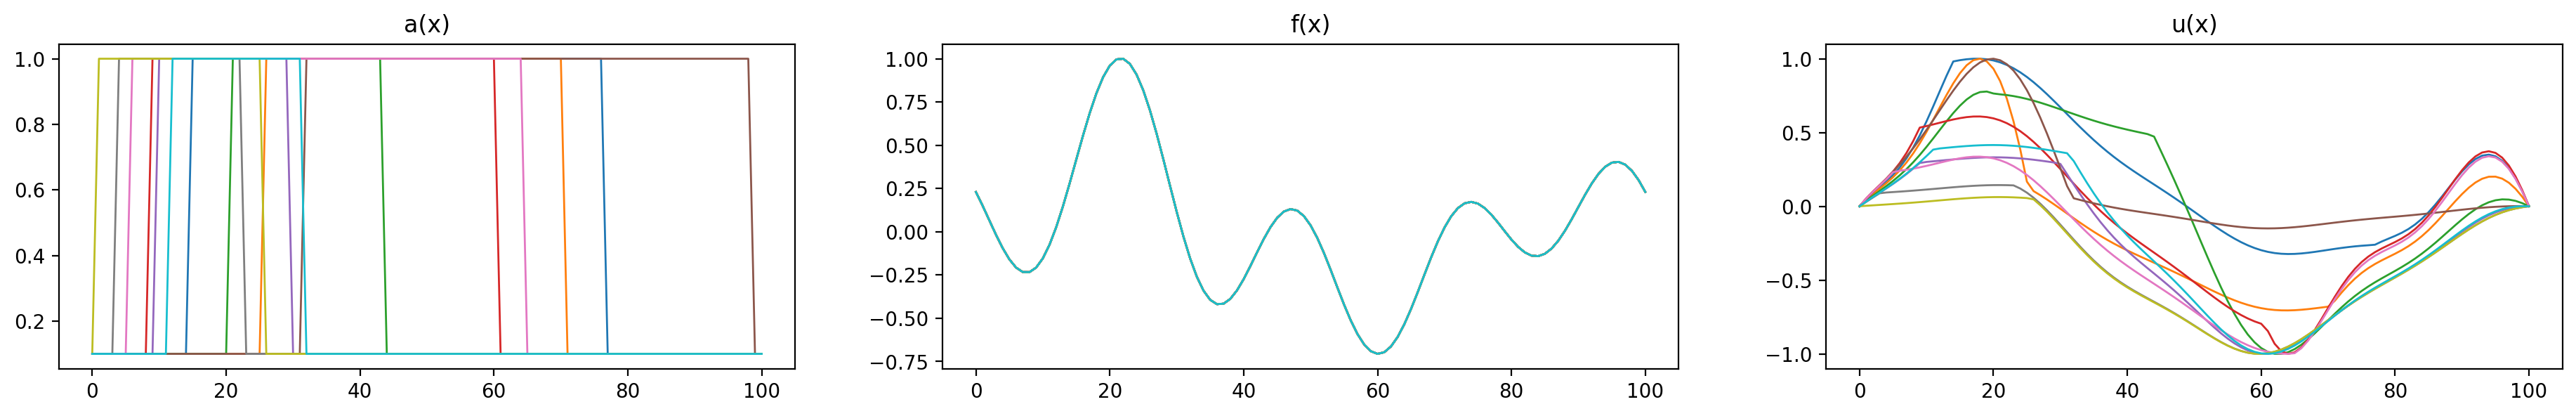

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(23, 3))

for i, n in enumerate([r"a(x)", r"f(x)", r"u(x)"]):
    ax[i].set_title(n)

for s in range(10):
    for i in range(datasets_3[0].shape[1]):
        ax[i].plot(datasets_3[0][s, i] / jnp.max(abs(datasets_3[0][s, i])), linewidth=1.0)
    ax[-1].plot(datasets_3[1][s] / jnp.max(abs(datasets_3[1][s])), linewidth=1.0)

In [ ]:
datasets_3[0].shape

(1400, 2, 101)

# Models

## Needed code for unsupervised learning for 1D

In [ ]:
@partial(jax.jit, static_argnames=['h'])
def derivative(a, h):
    d_a = (jnp.roll(a, -1, axis=0) - jnp.roll(a, 1, axis=0)) / (2*h)
    d_a = d_a.at[0].set((-3*a[0]/2 + 2*a[1] - a[2]/2)/h)
    d_a = d_a.at[-1].set((a[-3]/2 - 2*a[-2] + 3*a[-1]/2)/h)
    return d_a

def compute_upper_bound(y, u, a, b, f, C_f):
    dy = derivative(y, h=1/len(a))
    du = derivative(u, h=1/len(a))
    return jnp.sqrt(jnp.trapz((y - a * du)**2 / a, dx=1/len(a))) + C_f * jnp.sqrt(jnp.trapz((f + dy - b * u)**2, dx=1/len(a)))

def compute_J(a, b, u1, u2):
    d_u1 = derivative(u1, h=1/len(a))
    d_u2 = derivative(u2, h=1/len(a))
    return jnp.sqrt(jnp.trapz(a * (d_u1 - d_u2)**2 + b * (u1 - u2)**2, dx=1/len(a)))

def compute_loss_with_boudaries(y, u, a, b, f, C_f, weight):
    return compute_upper_bound(y, u, a, b, f, C_f)  + weight * jnp.sqrt(u[0]**2 + u[-1]**2)

def compute_loss(model, input, weight):
    output = vmap(lambda z: model(z), in_axes=(0,))(input)
    u, y = output[:, 0], output[:, 1]
    a, b, f = input[:, 0], input[:, 1], input[:, 2]
    C_f = jnp.max(a, axis=1) / jnp.pi
    loss = jnp.mean(vmap(compute_loss_with_boudaries, in_axes=(0, 0, 0, 0, 0, 0, None))(y, u, a, b, f, C_f, weight))
    return loss

compute_loss_and_grads = eqx.filter_value_and_grad(compute_loss)

@eqx.filter_jit
def make_step(model, input, optim, opt_state, weight):
    loss, grads = compute_loss_and_grads(model, input, weight)
    updates, opt_state = optim.update(grads, opt_state, model)
    model = eqx.apply_updates(model, updates)
    return loss, model, opt_state

def compute_loss_fsno(model, input, analysis, synthesis, weight):
    output = vmap(lambda z: model(z, analysis, synthesis), in_axes=(0,))(input)
    u, y = output[:, 0], output[:, 1]
    a, b, f = input[:, 0], input[:, 1], input[:, 2]
    C_f = jnp.max(a, axis=1) / jnp.pi
    loss = jnp.mean(vmap(compute_loss_with_boudaries, in_axes=(0, 0, 0, 0, 0, 0, None))(y, u, a, b, f, C_f, weight))
    return loss

compute_loss_and_grads_fsno = eqx.filter_value_and_grad(compute_loss_fsno)

@eqx.filter_jit
def make_step_fsno(model, input, optim, opt_state, analysis, synthesis, weight):
    loss, grads = compute_loss_and_grads_fsno(model, input, analysis, synthesis, weight)
    updates, opt_state = optim.update(grads, opt_state, model)
    model = eqx.apply_updates(model, updates)
    return loss, model, opt_state

## `DilResNet Model`

In [ ]:
class DilatedConvBlock(eqx.Module):
    convolutions: list
    activation: Callable

    def __init__(self, channels, dilations_D, kernel_sizes_D, key, activation=relu):
        # 1D example: channels = [3, 40, 40, 1], dilations_D = [[1,], [1,], [1]], kernel_sizes_D = [[3,], [3,], [3,]]
        # 2D example: channels = [3, 40, 40, 1], dilations_D = [[4, 4], [3, 3], [2, 1]], kernel_sizes_D = [[3, 4], [3, 4], [4, 5]]
        kernel_sizes_D = [[k if k%2 == 1 else k+1 for k in kernel_sizes] for kernel_sizes in kernel_sizes_D]
        paddings_D = [[d*(k//2) for d, k in zip(dilations, kernel_sizes)] for dilations, kernel_sizes in zip(dilations_D, kernel_sizes_D)]
        keys = random.split(key, len(channels))
        D = len(kernel_sizes_D[0])
        self.convolutions = [eqx.nn.Conv(num_spatial_dims=D, in_channels=f_i, out_channels=f_o, dilation=d, kernel_size=k, padding=p, key=key) for f_i, f_o, d, k, p, key in zip(channels[:-1], channels[1:], dilations_D, kernel_sizes_D, paddings_D, keys)]
        self.activation = activation

    def __call__(self, x):
        for conv in self.convolutions[:-1]:
            x = self.activation(conv(x))
        x = self.convolutions[-1](x)
        return x

    def linear_call(self, x):
        for conv in self.convolutions:
            x = conv(x)
        return x

class DilatedResNet(eqx.Module):
    encoder: eqx.Module
    decoder: eqx.Module
    processor: list
    activation: Callable

    def __init__(self, key, channels, n_cells, activation=relu, kernel_size=3, D=1):
        in_channels, processor_channels, out_channels = channels
        keys = random.split(key, 3)
        self.encoder = DilatedConvBlock([in_channels, processor_channels], [[1,]*D,], [[kernel_size,]*D,], keys[0])
        self.decoder = DilatedConvBlock([processor_channels, out_channels], [[1,]*D,], [[kernel_size,]*D,], keys[1])
        keys = random.split(keys[2], n_cells)
        channels_ = [processor_channels,]*8
        dilations = [[1,]*D, [2,]*D, [4,]*D, [8,]*D, [4,]*D, [2,]*D, [1,]*D]
        kernel_sizes = [[kernel_size,]*D,]*7
        self.processor = [DilatedConvBlock(channels_, dilations, kernel_sizes, key, activation=activation) for key in keys]
        self.activation = activation

    def __call__(self, x):
        x = self.encoder(x)
        for pr in self.processor[:-1]:
            x = self.activation(pr(x)) + x
        x = self.processor[-1](x) + x
        x = self.decoder(x)
        return x

    def linear_call(self, x):
        x = self.encoder(x)
        for pr in self.processor:
            x = pr(x) + x
        x = self.decoder(x)
        return x

## `fSNO Model`

In [ ]:
def get_analysis_data(N, Gauss, Polynomial, grid=None):
    x, w = Gauss(N) # parameters of quadrature
    P = []
    Q = []
    D_inv = []

    for n in range(N):
        p = Polynomial(n, x) # evaluate polynomials
        d = np.sum(w * p**2) # compute scalar product
        P.append(p)
        D_inv.append(1/d)
        if not (grid is None):
            q = Polynomial(n, grid)
            Q.append(q)

    A = np.vstack(P).T
    D_inv = np.diag(D_inv)

    analysis_data = [A, D_inv, w, x]
    if not (grid is None):
        analysis_data.append(np.vstack(Q).T)
    return analysis_data

def build_matrices(k, analysis_data):
    An = (analysis_data[1] @ analysis_data[0].T * analysis_data[2])[:k, :]
    Sn = analysis_data[0][:, :k] if len(analysis_data) == 4 else analysis_data[-1][:, :k]
    return jnp.array(An), jnp.array(Sn)

def get_transform_data(N, k, Gauss, Polynomial, grid=None):
    analysis_data = get_analysis_data(N, Gauss, Polynomial, grid=grid)
    transforms = build_matrices(k, analysis_data)
    transform_data = {
        "weights": jnp.array(analysis_data[2]),
        "points": jnp.array(analysis_data[3]),
        "analysis": transforms[0],
        "synthesis": transforms[1]
    }
    return transform_data

def Chebyshev_1(N, k, grid=None):
    Gauss = scp.roots_chebyt
    Polynomial = scp.eval_chebyt
    return get_transform_data(N, k, Gauss, Polynomial, grid=grid)

poly_data = {
    "Chebyshev_t": {
        "nodes": lambda n, alpha: scp.roots_chebyt(n)[0],
        "interval": [-1, 1],
        "transform": lambda n, alpha, grid=None, k=None: Chebyshev_1(n, n if k is None else k, grid=grid)
    }
}

def get_analysis(polynomials, parameters, N_points, M_keep):
    '''
    polynomials = [poly_name1, poly_name2, ...]
    parameters = [[a1, b1], [a2, b2], ...]
    N_points = [n1, n2, ...] number of points used to approximate coefficients
    M_keep = [m1, m2, ...] number of modes to keep
    return = [A1, A2, ...] matrices with shapes [(m1, n1), (m2, n2), ...]
    '''
    a_operators = []
    for poly_name, param, n, m in zip(polynomials, parameters, N_points, M_keep):
        A = poly_data[poly_name]["transform"](n, param, k=m)['analysis']
        a_operators.append(A)
    return a_operators

def get_synthesis(polynomials, parameters, grids, M_keep):
    '''
    polynomials = [poly_name1, poly_name2, ...]
    parameters = [[a1, b1], [a2, b2], ...]
    grids = [grid1, grid2, ...] grids (jax arrays) used for interpolation, if some grid is K (int), the standard grid with K points is used
    M_keep = [m1, m2, ...] number of modes keept
    return = [S1, S2, ...] matrices with shapes [(len(grid1), m1), (len(grid2), m2), ...] if gridK is K (int), the output is (K, mk)
    '''
    s_operators = []
    for poly_name, param, grid, m in zip(polynomials, parameters, grids, M_keep):
        grid_ = None if type(grid) == int else grid
        N_ = grid if type(grid) == int else len(grid)
        if m > N_ and (type(grid) == int):
            grid_ = poly_data[poly_name]["nodes"](N_, param)
        S = poly_data[poly_name]["transform"](max(N_, m), param, grid=grid_, k=m)['synthesis']
        s_operators.append(S)
    return s_operators

def get_operators(transformation_type, **kwargs):
    '''
    transformation_type either 'analysis' or 'synthesis'
    wrapper for get_analysis and get_synthesis
    '''
    if transformation_type == 'analysis':
        output = get_analysis(kwargs['polynomials'], kwargs['parameters'], kwargs['N_points'], kwargs['M_keep'])
    else:
        output = get_synthesis(kwargs['polynomials'], kwargs['parameters'], kwargs['grids'], kwargs['M_keep'])
    return output

def apply_operators(data, operators, batch=False):
    '''
    data.shape = [n_features, x1, x2, ...] or [batch, n_features, x1, x2, ...] depending on batch
    operator = [M1, M2, ...]
    '''
    shift = 2 if batch else 1
    for i, O in enumerate(operators):
        n = i + shift
        transposition = [*range(1, n+1)] + [0] + [*range(n+1, len(data.shape))]
        if (data.dtype == jnp.complex128) or (O.dtype == jnp.complex128):
            data = data + 0j
            O = O + 0j
        data = jnp.transpose(dot_general(O, data, (((1,), (n)), ((), ()))), transposition)
    return data

def transform_data(data, polynomials, parameters, transformation_type, grids):
    '''
    data.shape = [batch, n_features, x1, x2, ...]
    polynomials = [poly_name1, poly_name2, ...]
    transformation_type either "analysis" or "synthesis"
    grids = [grid1, grid2, ...] if gridK is None, the outpu grid is a standard one with the number of points the same as for the input
    '''
    grids_ = [data.shape[2+i] if g is None else g for i, g in enumerate(grids)]
    N_points_ = data.shape[2:]
    O = get_operators(transformation_type, parameters=parameters, polynomials=polynomials, grids=grids_, M_keep=N_points_, N_points=N_points_)
    output = apply_operators(data, O, batch=True)
    if transformation_type == "synthesis":
        output = jnp.real(output)
    return output

In [ ]:
class fSNO(eqx.Module):
    encoder: eqx.Module
    decoder: eqx.Module
    conv: list
    processor: list
    activation: Callable

    def __init__(self, input_shape, features_out, N_layers, N_features, cell, key, activation=relu):
        features_in = input_shape[0]
        N_input = list(input_shape[1:])
        D = len(N_input)
        keys = random.split(key, 4)

        self.encoder = DilatedConvBlock([features_in, N_features], [[1]*D, ], [[1]*D, ], keys[0])
        self.decoder = DilatedConvBlock([N_features, features_out], [[1]*D, ], [[1]*D, ], keys[1])

        keys = random.split(keys[2], N_layers)
        self.processor = [cell(N_features, k) for k in keys]

        keys = random.split(keys[3], N_layers)
        self.conv = [eqx.nn.Conv(num_spatial_dims=D, in_channels=N_features, out_channels=N_features, kernel_size=[1,]*D, key=key) for key in keys]
        self.activation = activation

    def __call__(self, x, analysis, synthesis):
        x = self.encoder.linear_call(x)
        for pr, conv in zip(self.processor[:-1], self.conv[:-1]):
            y = conv(x)
            x = apply_operators(x, analysis)
            x = pr(x)
            x = apply_operators(x, synthesis)
            x = self.activation(x + y)
        y = self.conv[-1](x)
        x = apply_operators(x, analysis)
        x = self.processor[-1](x)
        x = apply_operators(x, synthesis)
        x = x + y
        x = self.decoder.linear_call(x)
        return x

## `UNet Model`

In [ ]:
class ConvNet(eqx.Module):
  convs: list
  activation: Callable

  def __init__(self, D, features, odd_kernel, key, N_convs, activation=relu):
      keys = random.split(key, N_convs)
      self.activation = relu
      self.convs = [eqx.nn.Conv(D, features, features, odd_kernel, padding=(odd_kernel - 1) // 2, key=key) for key in keys[:-1]]

  def __call__(self, x):
      for c in self.convs:
          x = self.activation(c(x))
      return x

class UNet(eqx.Module):
    transofrm_convs: list
    before_convs: list
    after_d_convs: list
    after_convs: list
    right_after_convs: list
    pool: list
    conv_t: list

    def __init__(self, D, staring_N, features, kernel_size, N_convs, key, operation=jnp.max, activation=relu, depth=5):
        input_features, internal_features, output_features = features
        features_layers = [internal_features*2**i for i in range(depth)]
        even_kernel = 2 * (kernel_size // 2)
        odd_kernel = 2 * (kernel_size // 2) + 1
        N_down = [staring_N//2**i for i in range(depth)]
        upsampling_kernels = []
        for i in range(depth-1):
            if 2*N_down[::-1][i] == N_down[::-1][i+1]:
                upsampling_kernels.append(even_kernel)
            else:
                upsampling_kernels.append(odd_kernel)

        # for the transformation of input and output
        keys = random.split(key, 3)
        self.transofrm_convs = [eqx.nn.Conv(D, input_features, internal_features, odd_kernel, padding=(odd_kernel - 1) // 2, key=keys[0])]
        self.transofrm_convs += [eqx.nn.Conv(D, internal_features, output_features, odd_kernel, padding=(odd_kernel - 1) // 2, key=keys[1])]

        # convolutions before downsampling
        keys = random.split(keys[-1], depth+1)
        self.before_convs = [ConvNet(D, features, odd_kernel, key, N_convs, activation=relu) for features, key in zip(features_layers, keys[:-1])]

        # convolutions after downsampling
        keys = random.split(keys[-1], depth)
        self.after_d_convs = [eqx.nn.Conv(D, feature, 2*feature, odd_kernel, padding=(odd_kernel - 1) // 2, key=key) for feature, key in zip(features_layers[:-1], keys[:-1])]

        # convolutions after upsampling
        keys = random.split(keys[-1], depth+2)
        self.after_convs = [ConvNet(D, features, odd_kernel, key, N_convs, activation=relu) for features, key in zip(features_layers, keys[:-1])][::-1]

        # transition conv right after upsampling
        keys = random.split(keys[-1], depth)
        self.right_after_convs = [eqx.nn.Conv(D, 2*feature, feature, odd_kernel, padding=(odd_kernel - 1) // 2, key=key) for feature, key in zip(features_layers[:-1], keys[:-1])][::-1]

        # pooling
        self.pool = [eqx.nn.AdaptivePool(N_down[i+1], D, operation) for i in range(depth-1)]

        # upsampling
        keys = random.split(keys[-1], depth-1)
        self.conv_t = [eqx.nn.ConvTranspose(D, f_in, f_out, kernel_size, padding=(kernel_size - 2) // 2, stride=2, key=key) for f_in, f_out, kernel_size, key in zip(features_layers[::-1][:-1], features_layers[::-1][1:], upsampling_kernels, keys)]

    def __call__(self, x):
        X = [self.before_convs[0](self.transofrm_convs[0](x))]
        for i, p in enumerate(self.pool):
            x_ = self.before_convs[i+1](self.after_d_convs[i](p(X[-1])))
            X.append(x_)

        x_ = self.after_convs[0](X[-1])

        for i, up in enumerate(self.conv_t):
          x_ = up(x_)
          x_ = self.after_convs[i+1](self.right_after_convs[i](jnp.vstack([X[len(X)-2-i], x_])))

        x_ = self.transofrm_convs[1](x_)
        return x_

In [ ]:
def get_DilResNet(features_train, key):
    input = features_train[0]
    D = len(input.shape[1:])

    # Parameters of model
    kernel_size = 3
    channels = [input.shape[0], 64, 2]
    n_cells = 5

    model = DilatedResNet(key, channels, n_cells)

    # Parameters of training
    N_epoch = 500
    batch_size = 40
    learning_rate = 2e-3

    model_data = {
        "model_name": "DilResNet",
        "model": model,
        "compute_loss": compute_loss
    }

    optimization_specification = {
        "learning_rate": learning_rate,
        "make_step": make_step,
        "N_epochs": N_epoch,
        "batch_size": batch_size,
    }

    return model_data, optimization_specification

def get_SNO(features_train, key):
    input = features_train[0]
    D = len(input.shape[1:])

    # Parameters of model
    polynomials = ["Chebyshev_t", ] * D
    parameters = [[0.1, 0.1],] * D
    M_keep = [20, ] * D
    N_points = input.shape[1:]
    grids = N_points

    data = {
        "polynomials": polynomials,
        "parameters": parameters,
        "grids": grids,
        "M_keep": M_keep,
        "N_points": N_points
    }

    synthesis = get_operators("synthesis", **data)
    analysis = get_operators("analysis", **data)

    kernel_size = 3
    n_conv_layers = 3
    cell = lambda features, key: DilatedConvBlock([features,]*(n_conv_layers + 1), [[1,]*D, ]*n_conv_layers, [[kernel_size,]*D, ]*n_conv_layers, key, activation=lambda x: x)

    input_shape = input.shape
    N_features_out = 2
    N_features = 34
    N_layers = 4

    model = fSNO(input_shape, N_features_out, N_layers, N_features, cell, key)

    # Parameters of training
    N_epoch = 500
    batch_size = 40
    learning_rate = 5e-3

    model_data = {
        "model_name": "fSNO",
        "model": model,
        "compute_loss": lambda model, input, weight: compute_loss_fsno(model, input, analysis, synthesis, weight),
        "analysis": analysis,
        "synthesis": synthesis
        }

    optimization_specification = {
        "learning_rate": learning_rate,
        "make_step": lambda model, input, optim, opt_state, weight: make_step_fsno(model, input, optim, opt_state, analysis, synthesis, weight),
        "N_epochs": N_epoch,
        "batch_size": batch_size
    }
    return model_data, optimization_specification


def get_UNet(features_train, key):
    input = features_train[0]

    N_convs = 4
    input_features = input.shape[0]
    internal_features = 32
    output_features = 2
    D = len(input.shape) - 1
    kernel_size = 3

    model = UNet(D, input.shape[1], [input_features, internal_features, output_features], kernel_size, N_convs, key, depth=3)

    # Parameters of training
    N_epoch = 500
    batch_size = 40
    learning_rate = 5e-3

    model_data = {
        "model_name": "UNet",
        "model": model,
        "compute_loss": compute_loss
    }

    optimization_specification = {
        "learning_rate": learning_rate,
        "make_step": make_step,
        "N_epochs": N_epoch,
        "batch_size": batch_size,
    }
    return model_data, optimization_specification

## Training Model

In [ ]:
def batch_generator_x(x, batch_size, key, shuffle=True):
    N_samples = len(x)
    list_of_indeces = jnp.linspace(0, N_samples-1, N_samples, dtype=jnp.int64)

    if shuffle:
        random.shuffle(key, list_of_indeces)

    list_x = x[list_of_indeces]

    n_batches = N_samples // batch_size
    if N_samples % batch_size != 0:
        n_batches += 1

    for k in range(n_batches):
        this_batch_size = batch_size

        if k == n_batches - 1:
            if N_samples % batch_size > 0:
                this_batch_size = N_samples % batch_size
        x = jnp.array(list_x[k * batch_size : k * batch_size + this_batch_size])

        yield x

In [ ]:
def train_on_epoch(generator, model, optimizer, opt_state, make_step_func, weight):
    epoch_loss = []
    for it, batch_of_x in enumerate(generator):
        batch_loss, model, opt_state = make_step_func(model, batch_of_x, optimizer, opt_state, weight)
        epoch_loss.append(batch_loss.item())

    return epoch_loss, model, opt_state

In [ ]:
def train_model(model_data, train_data, optimization_specification, weight, plot = True):
    """
    Input:
        model_data: dict with keys "model", "compute_loss"
        train_data: [features, targets]
        test_data: [features, targets]
        optimization_specification: dict with keys "optimizer", "make_step", "N_epochs", "opt_state" - optional

    Returns:
        model, train_loss, test_loss
    """
    model = model_data["model"]

    c = train_data[0].shape[0] // optimization_specification["batch_size"]
    keys = [value * c for value in np.arange(50, 1050, 50)]
    values = [0.5, ] * len(keys)
    dict_lr = dict(zip(keys, values))

    sc = optax.piecewise_constant_schedule(optimization_specification["learning_rate"], dict_lr)
    if model_data['model_name']=='FNO':
        optimizer = optax.experimental.split_real_and_imaginary(optax.adamw(sc, weight_decay=1e-2))
    else:
        optimizer = optax.adamw(sc, weight_decay=1e-2)
    opt_state = optimizer.init(eqx.filter(model, eqx.is_array))
    train_losses, test_losses = [], []


    iterations = tqdm(range(optimization_specification["N_epochs"]), desc='N_epochs')
    iterations.set_postfix({'train epoch loss': jnp.nan})

    for it in iterations:
        key = random.PRNGKey(it)
        generator = batch_generator_x(train_data[0], optimization_specification["batch_size"], key=key, shuffle=True)
        epoch_loss, model, opt_state = train_on_epoch(generator, model, optimizer, opt_state, optimization_specification['make_step'], weight)
        iterations.set_postfix({'train epoch loss': epoch_loss})
        train_losses.append(jnp.array(epoch_loss).mean())
        a, b = train_data[0][:, 0], train_data[0][:, 1]
        if model_data["model_name"] == 'fSNO':
            ouput = vmap(lambda z: model(z, model_data['analysis'], model_data['synthesis']), in_axes=(0,))(train_data[0])[:, 0]
        else:
            ouput = vmap(model)(train_data[0])[:, 0]
        energy_norm = vmap(compute_J, in_axes=(0, 0, 0, 0))(a, b, train_data[1], ouput)

        if plot:
            display.clear_output(wait=True)
            fig, axes = plt.subplots(1, 3, figsize=(14, 4))

            axes[0].set_title(r'Loss')
            axes[0].set_yscale("log")
            axes[0].plot(train_losses, color='red')

            axes[1].set_title(r"Energy norm")
            axes[1].set_yscale("log")
            axes[1].plot(energy_norm, ".", color="red")

            axes[2].plot(ouput[0], color='red', label='pred')
            axes[2].plot(train_data[1][0], color='green', label='true')
            plt.legend()

            plt.tight_layout()
            plt.show()
    return model, train_losses

In [ ]:
def train_run(model_name, dataset, train_size = None, weight = None, plot = True):
    N = dataset[0].shape[-1]
    features_ = dataset[0]
    targets_ = dataset[1]

    if features_.shape[1] == 2:
        features_ = jnp.concatenate([features_[:, :1], jnp.zeros([features_.shape[0], 1, features_.shape[-1]]), features_[:, 1:]], axis=1)

    features_train, targets_train = features_[:1200], targets_[:1200]
    features_test, targets_test = features_[1200:], targets_[1200:]

    if train_size != None:
        features_train, targets_train = features_train[:train_size], targets_train[:train_size]

    key = random.PRNGKey(123)
    if model_name == "DilResNet":
        model_data, optimization_specification = get_DilResNet(features_train, key)
    elif model_name == "fSNO":
        model_data, optimization_specification = get_SNO(features_train, key)
    elif model_name == 'UNet':
        model_data, optimization_specification = get_UNet(features_train, key)

    if weight == None:
        weight = 10
    model, train_losses = train_model(model_data, [features_train, targets_train], optimization_specification, weight, plot=plot)

    return model, train_losses, [features_train, targets_train], [features_test, targets_test], model_data

In [ ]:
def test_model(model, train_data, test_data, model_data):
    '''
    apply_model: function that takes features and output predictions
    train_data: [features, targets]
    test_data: [features, targets]
    description: compute test and train errors
    '''
    a, b = train_data[0][:, 0], train_data[0][:, 1]
    if model_data["model_name"] == 'fSNO':
        ouput = vmap(lambda z: model(z, model_data['analysis'], model_data['synthesis']), in_axes=(0,))(train_data[0])[:, 0]
    else:
        ouput = vmap(model)(train_data[0])[:, 0]
    train_errors = vmap(compute_J, in_axes=(0, 0, 0, 0))(a, b, train_data[1], ouput)

    a, b = test_data[0][:, 0], test_data[0][:, 1]
    if model_data["model_name"] == 'fSNO':
        ouput = vmap(lambda z: model(z, model_data['analysis'], model_data['synthesis']), in_axes=(0,))(test_data[0])[:, 0]
    else:
        ouput = vmap(model)(test_data[0])[:, 0]
    test_errors = vmap(compute_J, in_axes=(0, 0, 0, 0))(a, b, test_data[1], ouput)

    return train_errors, test_errors

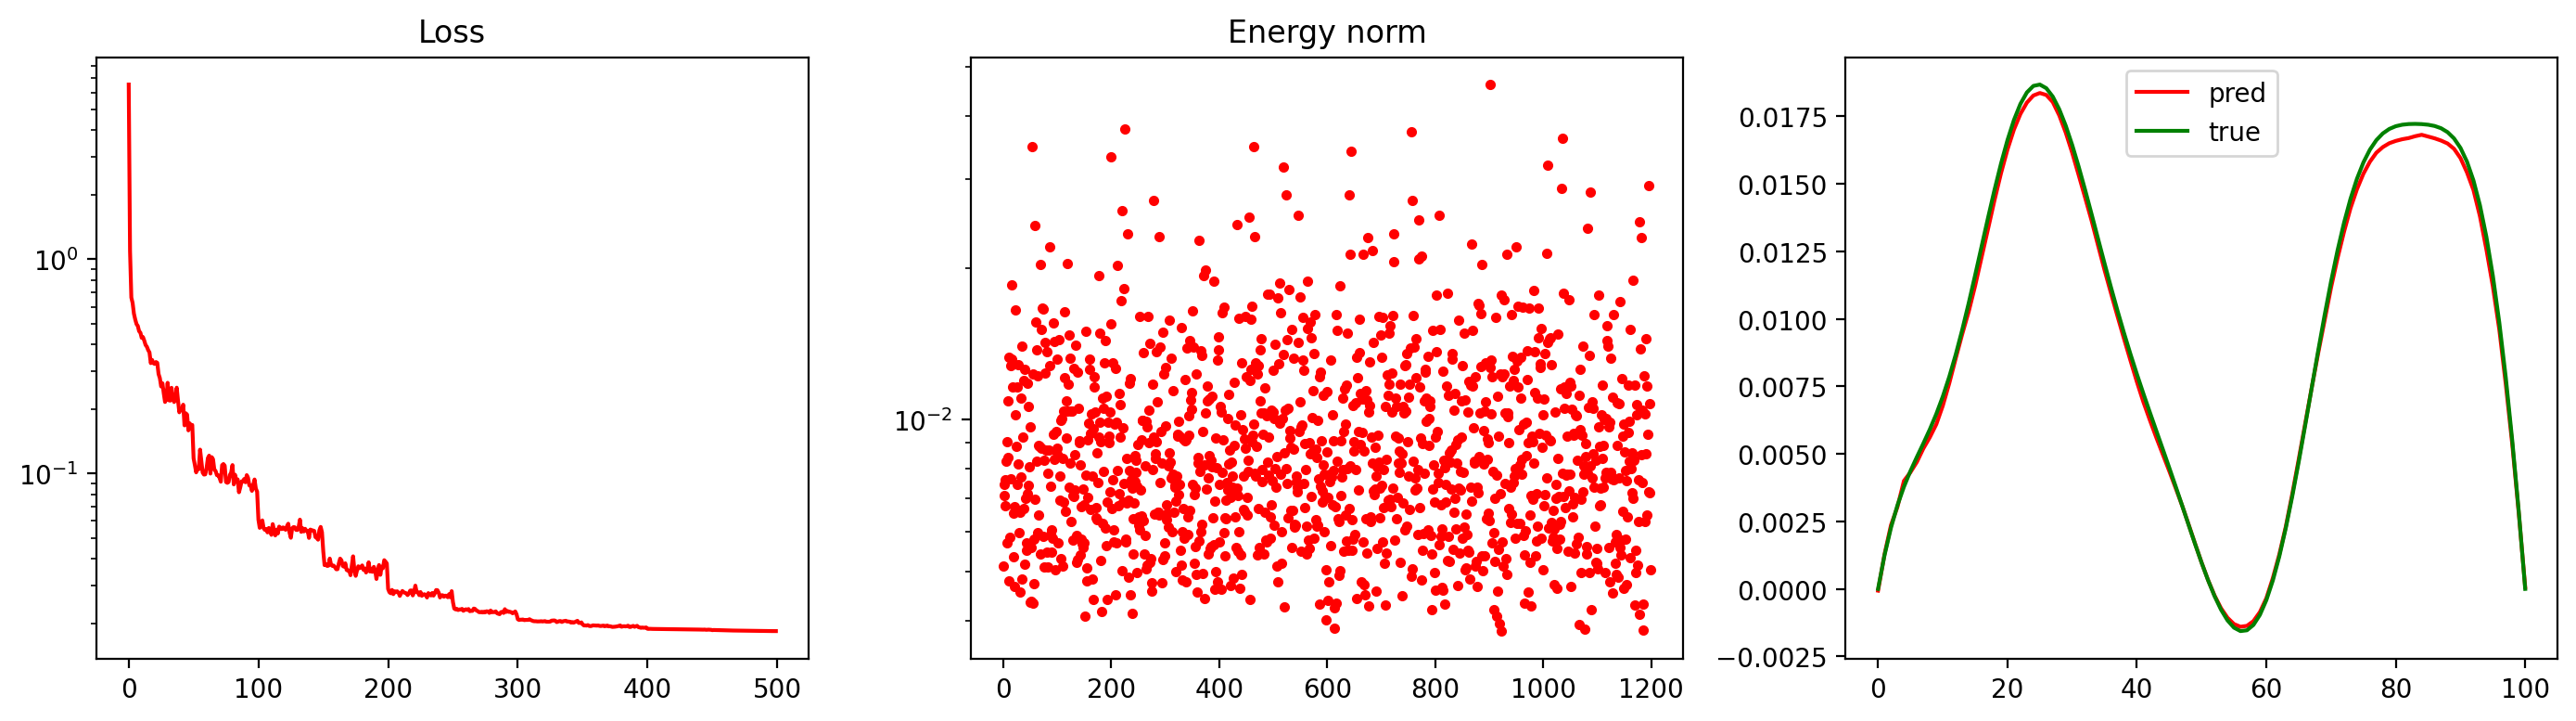

N_epochs: 100%|██████████| 500/500 [15:11<00:00,  1.82s/it, train epoch loss=[0.017690330743789673, 0.020520702004432678, 0.017955053597688675, 0.017076004296541214, 0.01708885282278061, 0.02033846080303192, 0.01707223616540432, 0.017250362783670425, 0.01636614464223385, 0.01853717863559723, 0.01725841499865055, 0.020318374037742615, 0.019080860540270805, 0.019420279189944267, 0.017583025619387627, 0.01619473472237587, 0.020798204466700554, 0.018392885103821754, 0.020247632637619972, 0.01881605200469494, 0.017851784825325012, 0.01774659752845764, 0.019379369914531708, 0.01944056898355484, 0.019072413444519043, 0.01924024522304535, 0.016727229580283165, 0.018427586182951927, 0.01686062477529049, 0.018395688384771347]]


In [ ]:
model, train_losses, train_data, test_data, model_data = train_run('fSNO', datasets_1)

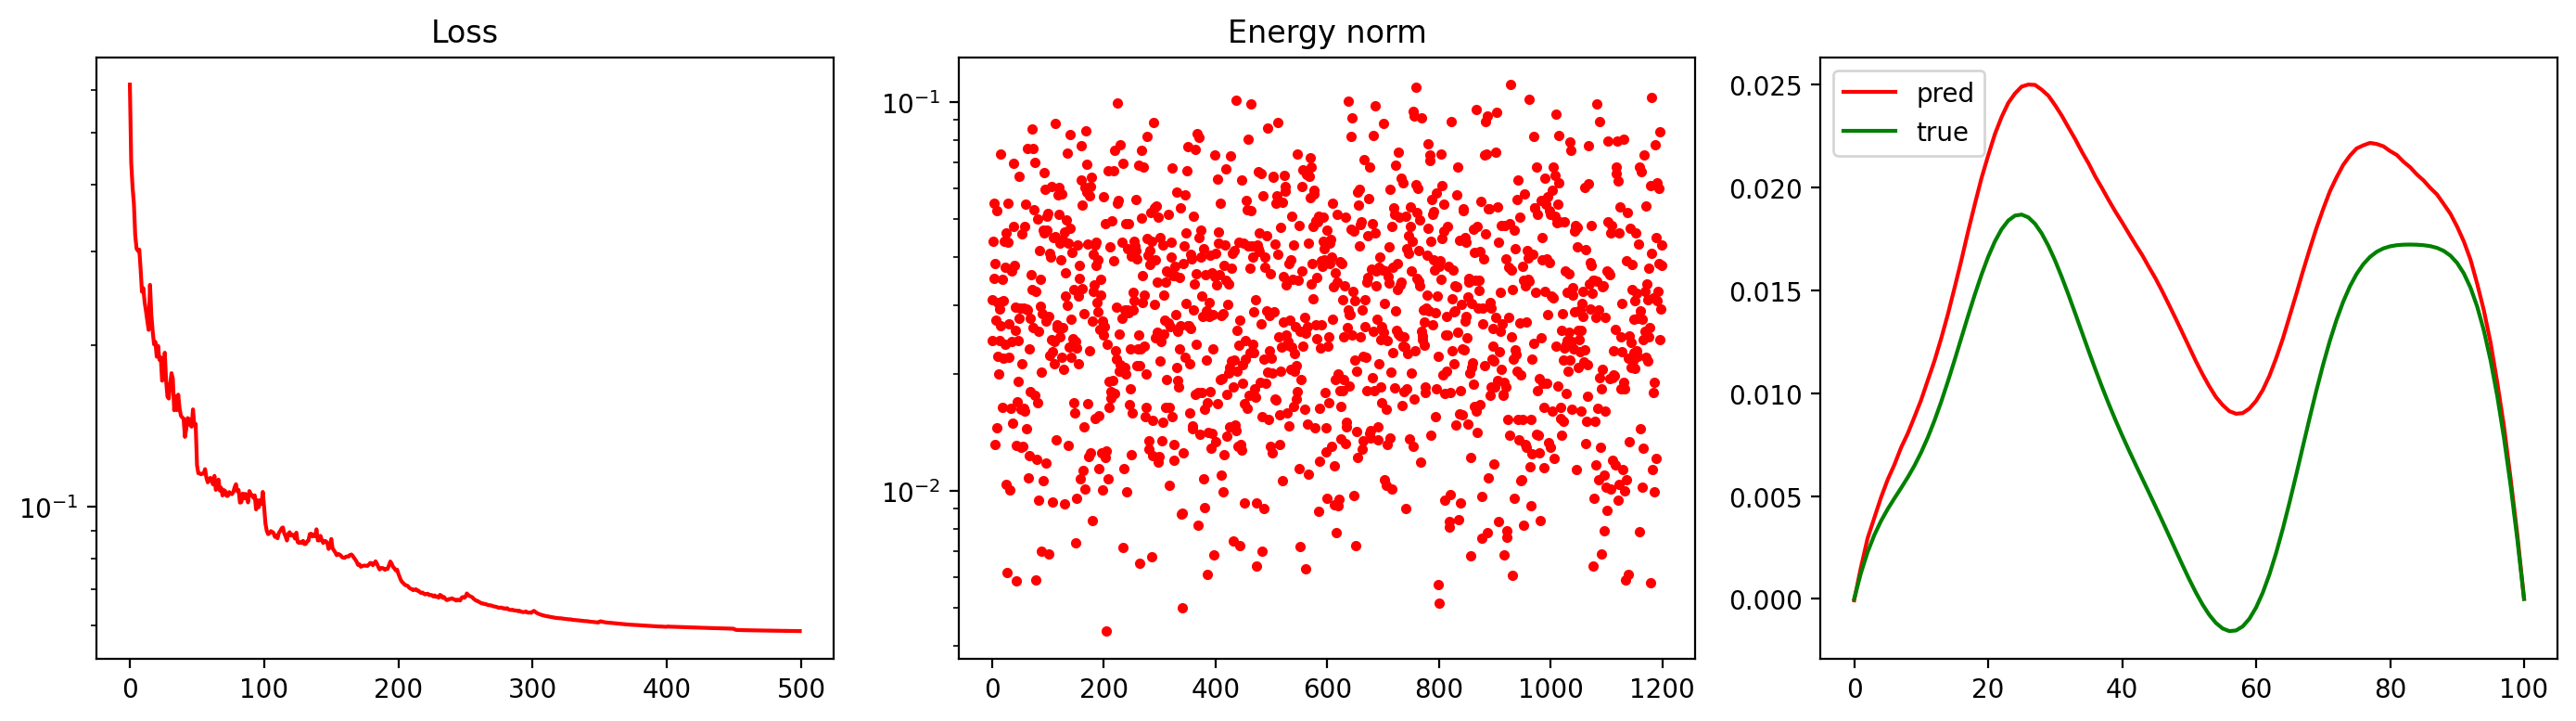

N_epochs: 100%|██████████| 500/500 [15:43<00:00,  1.89s/it, train epoch loss=[0.05994227156043053, 0.0557093508541584, 0.05889831855893135, 0.061536211520433426, 0.05779394134879112, 0.05925791338086128, 0.058456916362047195, 0.055704664438962936, 0.05620570108294487, 0.059339672327041626, 0.05680631473660469, 0.0603862889111042, 0.06177189573645592, 0.05789436027407646, 0.06154992803931236, 0.05469111353158951, 0.061710175126791, 0.05761511251330376, 0.06668534129858017, 0.061000701040029526, 0.05644824728369713, 0.0545307993888855, 0.06237838417291641, 0.0543876551091671, 0.061338212341070175, 0.06318379938602448, 0.05504381284117699, 0.054653145372867584, 0.0509488545358181, 0.06012286618351936]]


In [ ]:
model, train_losses, train_data, test_data, model_data = train_run('UNet', datasets_1)

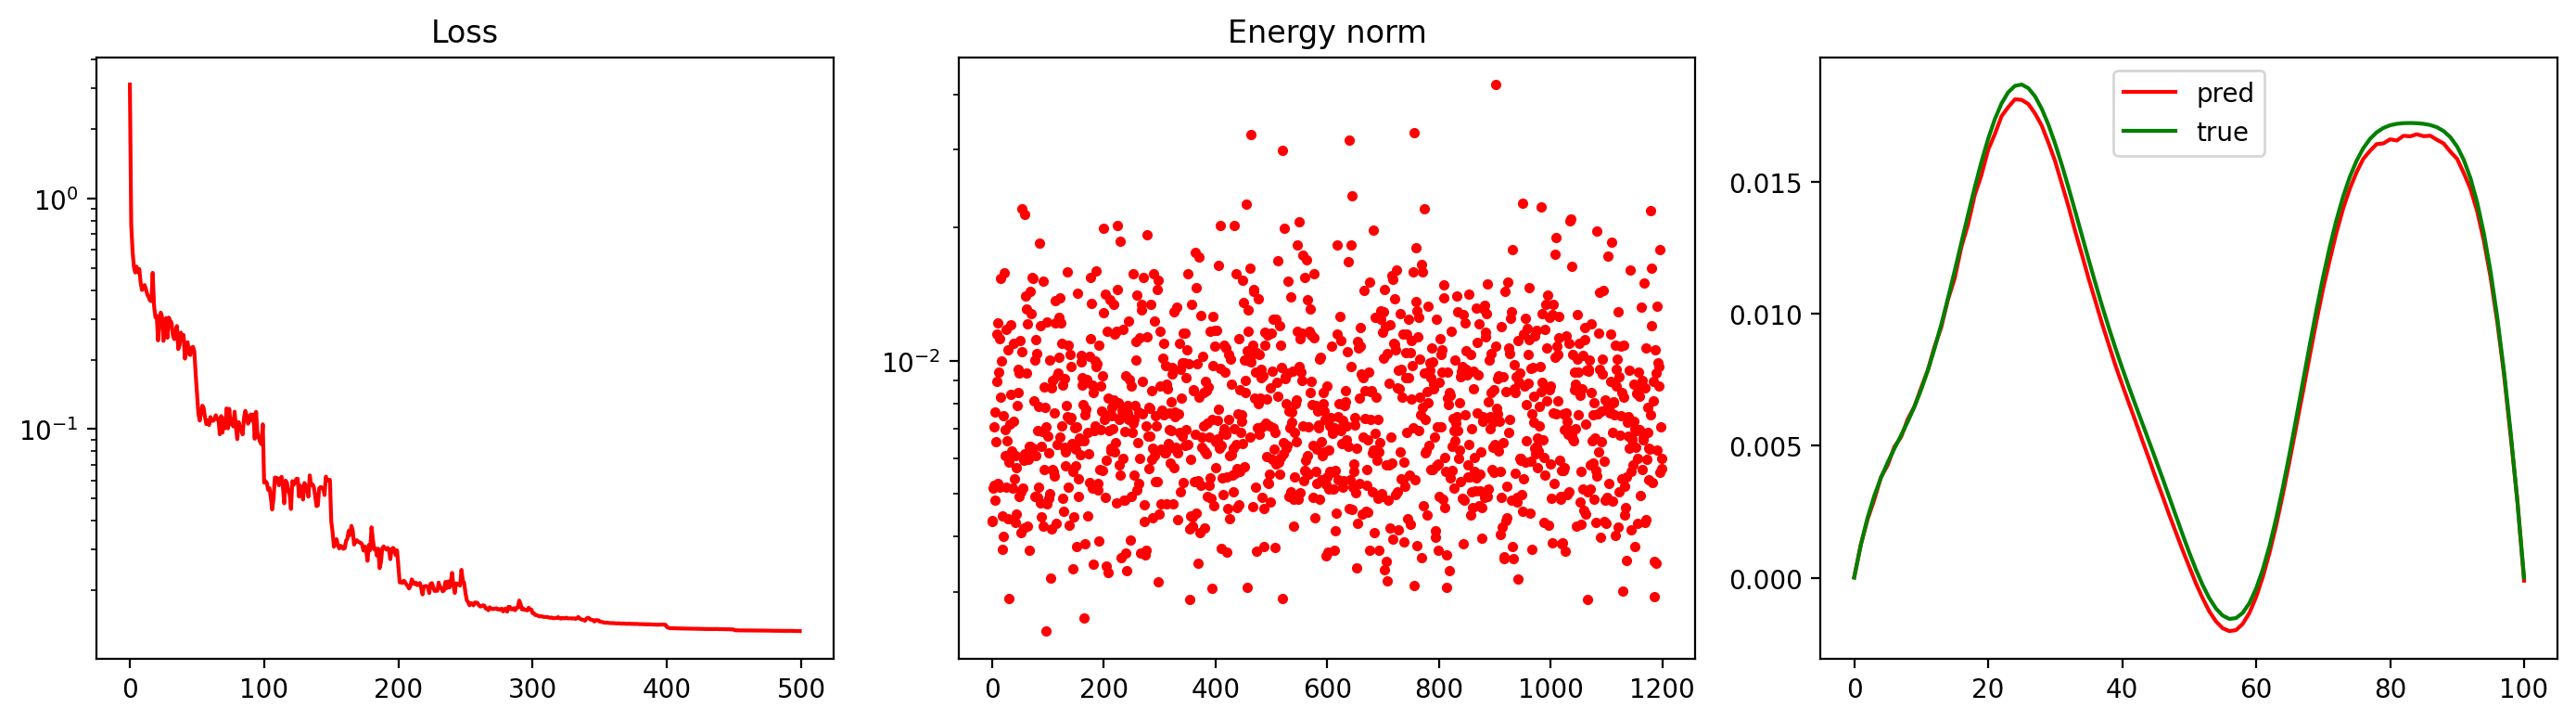

N_epochs: 100%|██████████| 500/500 [17:11<00:00,  2.06s/it, train epoch loss=[0.013298687525093555, 0.01361179817467928, 0.01235369872301817, 0.012916299514472485, 0.012017897330224514, 0.013619253411889076, 0.012521298602223396, 0.012963305227458477, 0.012753354385495186, 0.012996286153793335, 0.01275926548987627, 0.015517698600888252, 0.013592910952866077, 0.013469270430505276, 0.013405213132500648, 0.012747811153531075, 0.014443011954426765, 0.012958494015038013, 0.01464671827852726, 0.01347844023257494, 0.013239252381026745, 0.012896478176116943, 0.014095202088356018, 0.013931842520833015, 0.014545390382409096, 0.01330991555005312, 0.01233076211065054, 0.01349609810858965, 0.01195156667381525, 0.013722307980060577]]


In [ ]:
model, train_losses, train_data, test_data, model_data = train_run('DilResNet', datasets_1)